The objective of this kernel is to create a model that can predict household povertly levels using both individual and household level data. The poverty levels are classified from 1-4, 1 being extreme poverty, and 4 being non vulnerable households. While this challenge presents a fairly straightforward classification problem, the data is given for the individual, but we must predict household level data.

In [1]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', 500)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

import warnings
warnings.filterwarnings('ignore')

# Set a few modeling defaults
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Scoring
from sklearn.metrics import f1_score, classification_report

In [2]:
# Reading in data
train_df = pd.read_csv(r"C:\Users\Preston Overson\Documents\Python Scripts\Data\cr_train.csv")
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


# Data Exploration and Cleaning

Now that I have read in the data I am going to do some data exploration and cleaning

(9557, 143)


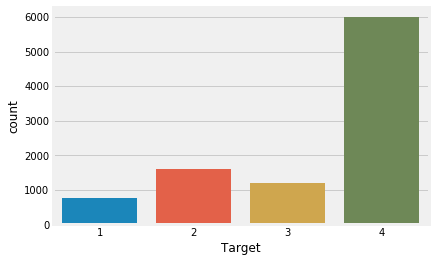

In [3]:
y = train_df.Target
sns.countplot(y)
print (train_df.shape)

 I changed the target column to 'y' to simplify things later on. The count plot above gives an idea of the distribution of the target. Most of the households score a 4, so we will have to balance the data later on.

One problem with the data is incorrect values for poverty within households. All of the individuals in the same house should have the same poverty level, however this is not the case in the data. We are told that the head of houeshold's poverty level should be used as the "true" level. So we need to reflect this principle in the data. This is a bit beyond my coding capabilities, but I found another kernel that addresses this problem well [here](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough). Using this walk through, we first identify the households with unequal Target values. Then search for any households missing head of households, because this would make finding a "true" target more difficult for these houses.

In [4]:
# Groupby the household and figure out the number of unique values
all_equal = train_df.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
households_leader = train_df.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train_df.loc[train_df['idhogar'].isin(households_leader[households_leader == 0].index), :]
print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


If the 15 households without a head have differing values, that will be a more complicated problem, we may just need to fill with the mode, but first we will check to sese if any of these households have differing values.

In [5]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


Okay, luckily we dont have to deal with fixing the Target values for households missing heads.

Now we must adjust the other households that do have unequal targets so that they all are the same as their respective heads of household. This is done using the code from the kernel mentioned above

In [6]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train_df[(train_df['idhogar'] == household) & (train_df['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train_df.loc[train_df['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train_df.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


In [7]:
data = train_df

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [9]:
data['idhogar'].nunique()

2988

So it looks like there are 9556 individuals in the dataset, and there are 2988 households. The household and individual data must be merged somehow, and then predicted at the household level, then the household prediction needs to be attached back to the individuals.

In [10]:
data.isna().sum().sort_values(ascending=False).head(10)

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
techozinc            0
techoentrepiso       0
techocane            0
techootro            0
cielorazo            0
dtype: int64

It looks like there are a lot of missing values for rez_esc, v18q1, and v2a1. Since there are so many missing values, they most likely aren't random, and may mean they are N/A and should be filled with zeros, or some other number.

Looking at the documentation found [here](http://https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data):

rez_esc is a variable showing years behind in school (This could be not applicable for some people if they do not have children in school)

First we can look at the summary stats of age for households that have a recorded rez_esc variable, then we can compare these numbers to  the households with missing values.

In [11]:
print (data.loc[data['rez_esc'].notnull()]['age'].describe())
print (data.loc[data['rez_esc'].isnull()]['age'].describe())

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64
count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64


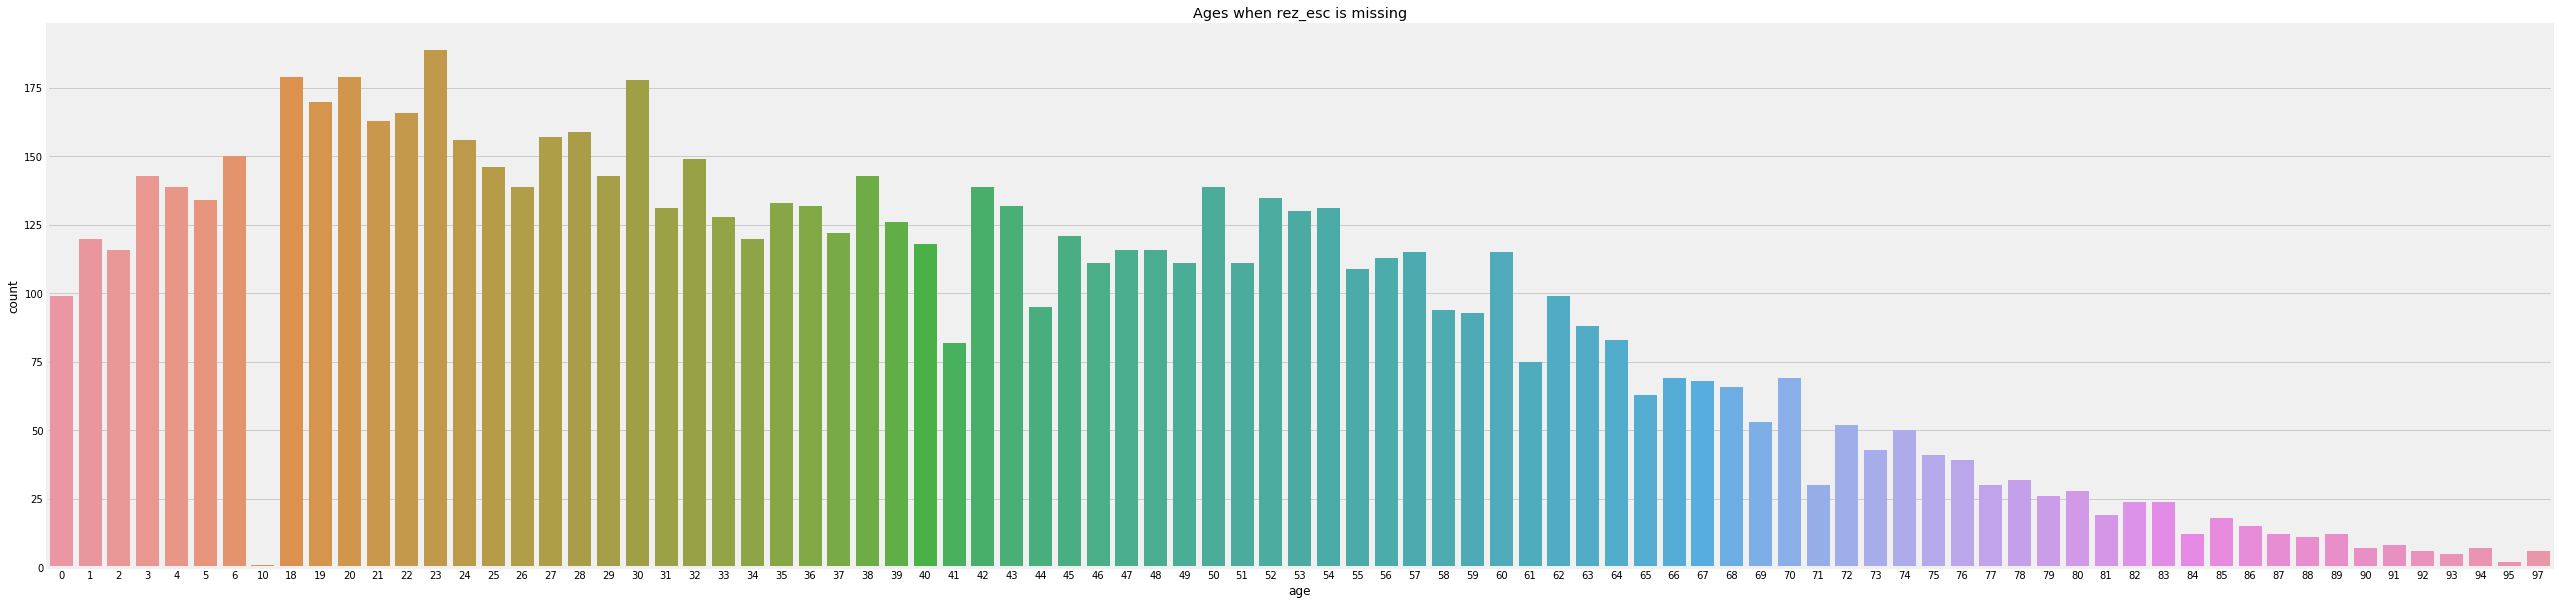

In [12]:
plt.figure(figsize=(40, 10))
plt.title("Ages when rez_esc is missing")
sns.countplot(data.loc[data['rez_esc'].isnull()]['age'])

The above information shows that rez_esc is only missing when the age of the individual is less than 7 years old or greater than 17. This variable is only defined for individuals that are between 7 and 17. For all other individuals I will fill zero.

In [13]:
data.loc[((data['age'] > 17) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

In [14]:
data['rez_esc'].isna().sum()

1

There is still one missing values to be imputed, I will try to impute them with the median in the family

In [15]:
data['rez_esc'] = data.groupby("idhogar")['rez_esc'].transform(lambda x: x.fillna(x.median()))

In [16]:
data['rez_esc'].isna().sum()

0

v18q1 is the number of tablets the household owns (This might mean they have no tablets, it looks like it was an extension of the v18q variable)

One thing I can do is look at the value count of the households with missing values and see if they reported any tablets at all

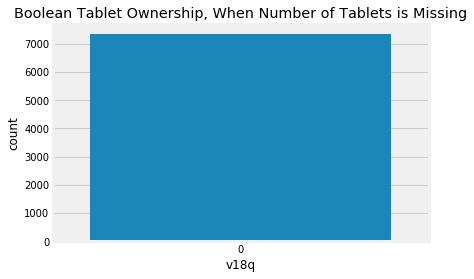

In [17]:
plt.title("Boolean Tablet Ownership, When Number of Tablets is Missing")
sns.countplot(data.loc[data['v18q1'].isnull()]['v18q'])

All of the missing v18q1 households, also reported that they did not own a tablet. So I can fill all these values in with zero.

In [18]:
data['v18q1'] = data['v18q1'].fillna(0)

v2a1 is the monthly rent payment (This might mean these people dont have a house, or that they own their house and therefore don't pay rent)

To figure out what to these values with it might be helpful to see a similare graph to the one above showing whether there ownership status. The following algorithm I found on another Kaggle users Kernel [found here](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough). This creates a single home ownership variable from the group of variables starting with 'tipoviv'

* tipovivi1, =1 own and fully paid house
* tipovivi2, "=1 own,  paying in installments"
* tipovivi3, =1 rented
* tipovivi4, =1 precarious
* tipovivi5, "=1 other(assigned,  borrowed)"

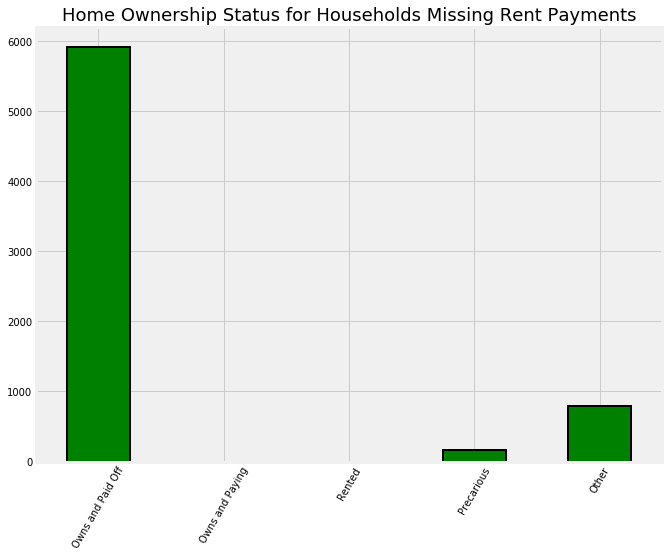

In [19]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

Here for the houses that are owned and paid off, these individuals are most likely not in poverty. I will check this below

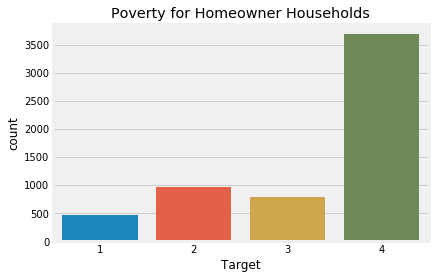

In [20]:
plt.title("Poverty for Homeowner Households")
sns.countplot(train_df.loc[data['tipovivi1'] == 1]['Target'])

Surprisingly the distribution of poverty for those that own a home looks similar to the general distribution for the entire training set. I will fill the rent for households that own as zero to reflect their actual rent payment. 

In [21]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0
data['v2a1'].isna().sum()

949

There are still 949 observations with missing rent payments I will fill these with the median, but I will also creat a new column indicating that this variable was origianlly missing. Since the person neither owns a house, or has a rent payment, it is important not to lose this information after we impute.

In [22]:
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1'] = data['v2a1'].fillna(data['v2a1'].median())
data['v2a1'].isna().sum()

0

meaneduc and SQBmeaned, also have missing values. Mean education is the mean years of education for individual 18+ in the household. The SQBmeaned is simply the meaneduc variable squared. This variable could be missing if there is not someone over the age of 18 in the household, or it could be missing randomly. Below I will look at some of the relationships between the missing meaneduc and other variables.

In [23]:
data.loc[data['meaneduc'].isnull()]['age'].describe()

count     5.000000
mean     18.400000
std       0.547723
min      18.000000
25%      18.000000
50%      18.000000
75%      19.000000
max      19.000000
Name: age, dtype: float64

In [24]:
data.loc[data['meaneduc'].isnull()]['idhogar'].value_counts()

faaebf71a    2
a874b7ce7    2
1b31fd159    1
Name: idhogar, dtype: int64

Lets look at one of the households that is missing this variable

In [25]:
data.loc[data['idhogar'] == 'a874b7ce7']

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,v2a1-missing
1840,ID_46ff87316,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,0.0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,0,1,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.0,64.0,NaN,324,4,False
1841,ID_69f50bf3e,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,0.0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,1,0,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.0,64.0,NaN,324,4,False


In the instance above it seems like this is a very young married couple aged 18. Looking at the stats for households missing this value, it seems like they are generally young. The max age in the households missing this variable is 19. Given this information, I will simply use the mean of the escolari variable for the heads of houshold.

In [26]:
meaneduc_nan=data[data['meaneduc'].isnull()][['idhogar','escolari']]
me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
for row in meaneduc_nan.iterrows():
    idx=row[0]
    idhogar=row[1]['idhogar']
    m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
    data.at[idx, 'meaneduc']=m
    data.at[idx, 'SQBmeaned']=m*m

In [27]:
data['meaneduc'].isna().sum()

0

Great! Now we have filled in all of the missing data. The only thing left to manipulate are the 4 object columns. First we need to see what these columns are, and what information they have

In [28]:
data.columns[data.dtypes==object]

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

In [29]:
data[['idhogar', 'dependency', 'edjefe', 'edjefa']].head(20)


,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no
5,2b58d945f,yes,11,no
6,2b58d945f,yes,11,no
7,d6dae86b7,yes,9,no
8,d6dae86b7,yes,9,no
9,d6dae86b7,yes,9,no


So really there are only three objkects to worry about because idhogar is just the household's id. So we need to investigate dependency, edjefe and edjefa. Comparing the 3 object variables to the idhogar, it looks like all of these are household level data.

Starting with dependency. This column has contains yes, no and integers. The documentation shows that this variable should be numerical, representing (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64). Luckily there seems to be a dependency squared variable called "SQBdependency" this column is numerical so we can use this to find out the dependency variable.

In [30]:
data['dependency']=np.sqrt(data['SQBdependency'])

In [31]:
data['dependency'].head(10)

0    0.0
1    8.0
2    8.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: dependency, dtype: float64

Okay looks good! Now we need to fix the edjefe and edjefa columns. These columns both look related, when one is no the other is a number. Below I am going to plot the counts for each possible entry to see if there are other non-numerical entries.

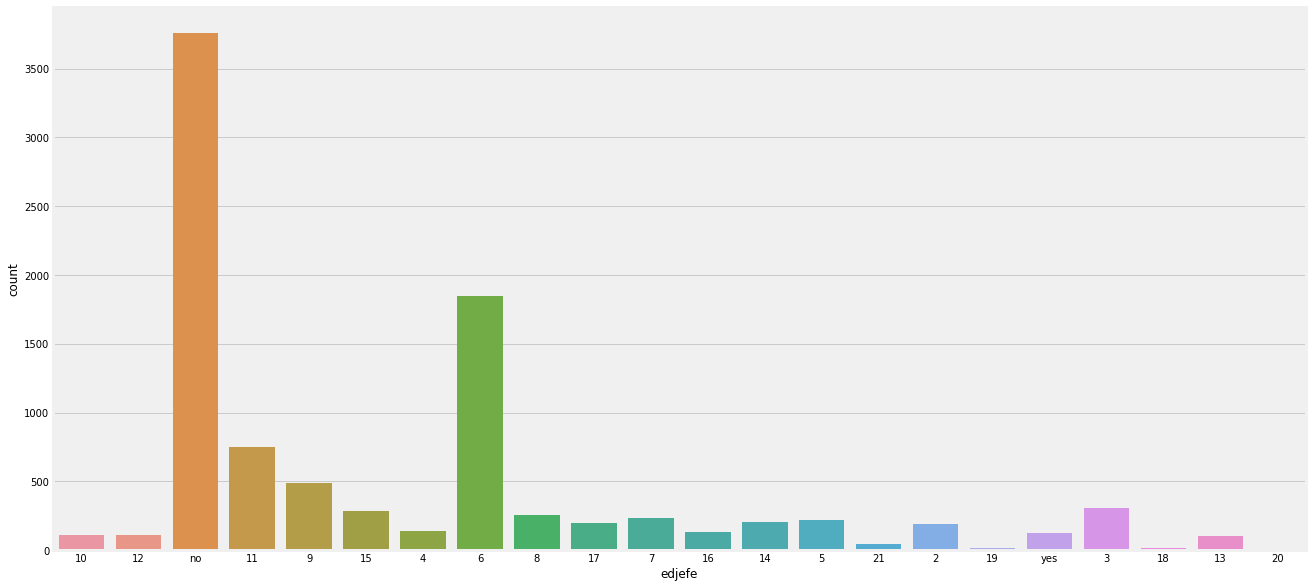

In [32]:
plt.figure(figsize=(20, 10))
sns.countplot(data['edjefe'])

So there is also a small fraction of yes entries additonal to the no entries. I think that no entries must mean that the "jefe" doesnt have education. There is a SQBedjefe variable that is the square of edjefe. I can use this column to check if I'm right.

In [33]:
data[['edjefe', 'SQBedjefe']].head(20)

,edjefe,SQBedjefe
0,10,100
1,12,144
2,no,0
3,11,121
4,11,121
5,11,121
6,11,121
7,9,81
8,9,81
9,9,81


In [34]:
data[(data['edjefe']=='yes')].head(10)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,v2a1-missing
601,ID_3ffc11a03,0.0,0,4,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,1,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3641ce2d1,0,2,2,2,8.0,yes,no,2.000000,0,1,0,0,0,0,0,0,0,1,2.0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,81,1,6561,4,1,0,4.00,64.00,4.000000,6561,2,False
602,ID_76cbd395d,0.0,0,4,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,3,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3641ce2d1,0,2,2,2,8.0,yes,no,2.000000,0,1,0,0,0,0,0,0,0,1,2.0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,73,9,5329,4,1,0,4.00,64.00,4.000000,5329,2,False
2392,ID_cb914fc3b,150000.0,0,6,0,1,1,0,0.0,0,1,1,0,2,2,0,3,3,3,3,6,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a7abf59cc,1,2,0,3,0.5,yes,no,3.500000,0,0,1,0,0,0,0,0,0,3,1.0,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,42,36,1764,9,1,1,1.00,0.25,12.250000,1764,4,False
2393,ID_48b1e8fb0,150000.0,0,6,0,1,1,0,0.0,0,1,1,0,2,2,0,3,3,3,3,5,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,a7abf59cc,1,2,0,3,0.5,yes,no,3.500000,0,1,0,0,0,0,0,0,0,3,1.0,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,12,25,144,9,1,1,1.00,0.25,12.250000,144,4,False
2394,ID_bdf3d8862,150000.0,0,6,0,1,1,0,0.0,0,1,1,0,2,2,0,3,3,3,3,1,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a7abf59cc,1,2,0,3,0.5,yes,no,3.500000,0,1,0,0,0,0,0,0,0,3,1.0,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,46,1,2116,9,1,1,1.00,0.25,12.250000,2116,4,False
2422,ID_6ec7ee687,0.0,0,4,0,1,1,0,0.0,0,2,2,0,1,1,0,3,3,3,3,6,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,698318dd7,0,3,2,3,2.0,yes,no,2.666667,0,0,1,0,0,0,0,0,0,2,1.5,1,0,0,0,0,0,0,1,2,1,0,0,0,0,0,1,0,41,36,1681,9,1,0,2.25,4.00,7.111112,1681,4,False
2423,ID_a1a5f5e09,0.0,0,4,0,1,1,0,0.0,0,2,2,0,1,1,0,3,3,3,3,1,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,698318dd7,0,3,2,3,2.0,yes,no,2.666667,0,1,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,0,0,1,2,1,0,0,0,0,0,1,0,74,1,5476,9,1,0,2.25,4.00,7.111112,5476,4,False
2424,ID_21ff47f96,0.0,0,4,0,1,1,0,0.0,0,2,2,0,1,1,0,3,3,3,3,1,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,

It looks like 'no' does mean 0 years of education, and the 'yes' means 1 year of schooling. It also looks like the square column is accurate compared to the numbers we do have for the 'edjefe' column. So I will fill in the edjefe column with the square root of the "SQBedjefe" column

In [35]:
data['edjefe']=np.sqrt(data['SQBedjefe'])

I can only assume that the edjefa column is similar to the edjefe, in that no means 0 and yes means 1. I will make these changes below

In [36]:
data['edjefa'] = data['edjefa'].replace(to_replace=['no', 'yes'], value=[0, 1])

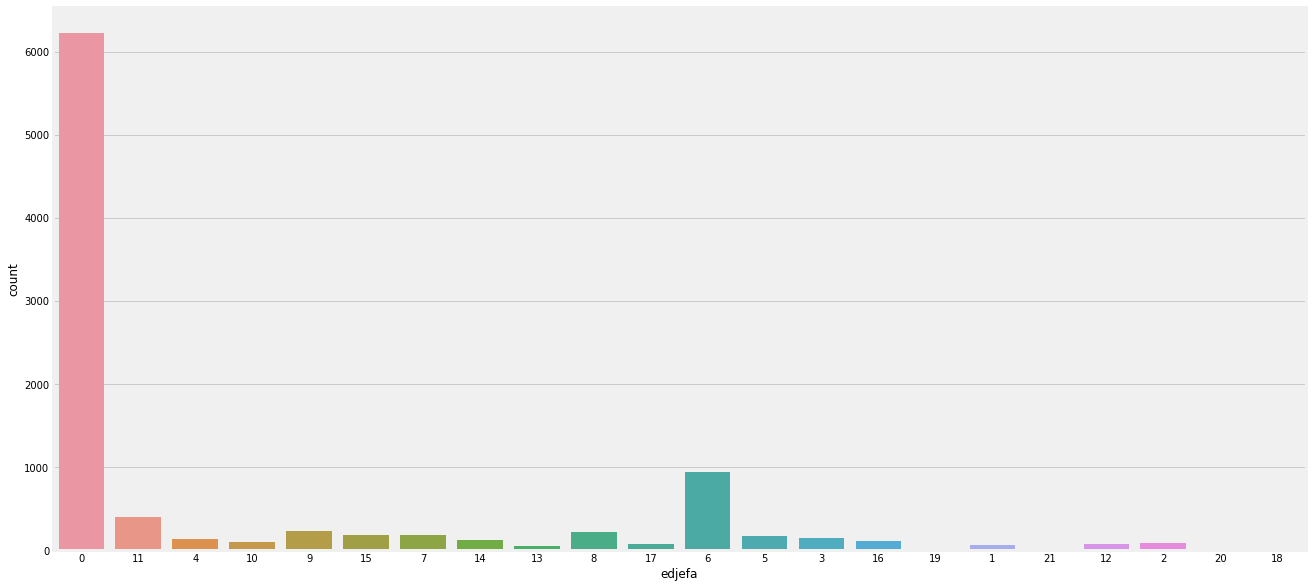

In [37]:
plt.figure(figsize=(20, 10))
sns.countplot(data['edjefa'])

Okay now we have all of the no values changed to 0 and all of the yes values changed to 0. Now we need to change the whole column to back to an integer datatype. After we will check to make sure all of the object data types are handled.

In [38]:
data['edjefa']=pd.to_numeric(data['edjefa'])
data.columns[data.dtypes==object]

Index(['Id', 'idhogar'], dtype='object')

Since we are only predicting the poverty levels of the head of households, now we can drop all of the data for the non head of households

In [39]:
heads = data.loc[data['parentesco1'] == 1, :]
heads.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,v2a1-missing
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4,False
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4,False
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4,False
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,121,1444,16,121,4,1.777778,1.0,121.0,1444,4,False
8,ID_1284f8aad,130000.0,1,2,0,1,1,0,0.0,0,1,1,2,1,3,2,2,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,d6dae86b7,2,2,0,4,1.0,9.0,0,10.0,0,0,0,1,0,0,0,0,0,1,4.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,30,81,900,16,81,4,16.000000,1.0,100.0,900,4,False


The squared data that is included in the dataset, is correlated to the original values. Since this is a classification problema and not a regression, we will only be using the original values.

In [40]:
data = data.drop(columns=['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'])

In [41]:
data.shape

(9557, 135)

Looking good, We can also drop the parenteso columns, because all of the individuals in the data set are head of households.

In [42]:
data = data.drop(columns=['parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
                          'parentesco7','parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12'])

I'm also worried that there are more columns that are similar, it looks like there are multiple measures for bedroom, overcrowding, number of children, and number of individuals in the household.

In [43]:
data = data.drop(columns=['r4t3', 'hhsize','tamhog'])

Okay, the data is looking pretty good now. I'm going to look at some of the correlation coeefficients with the target, so that I have some intuition, and understand better some of the more important features at this point. In the end I will be using a random forest so, this step isn't necessary, but could be helpful to make sure the most prominent features make sense.

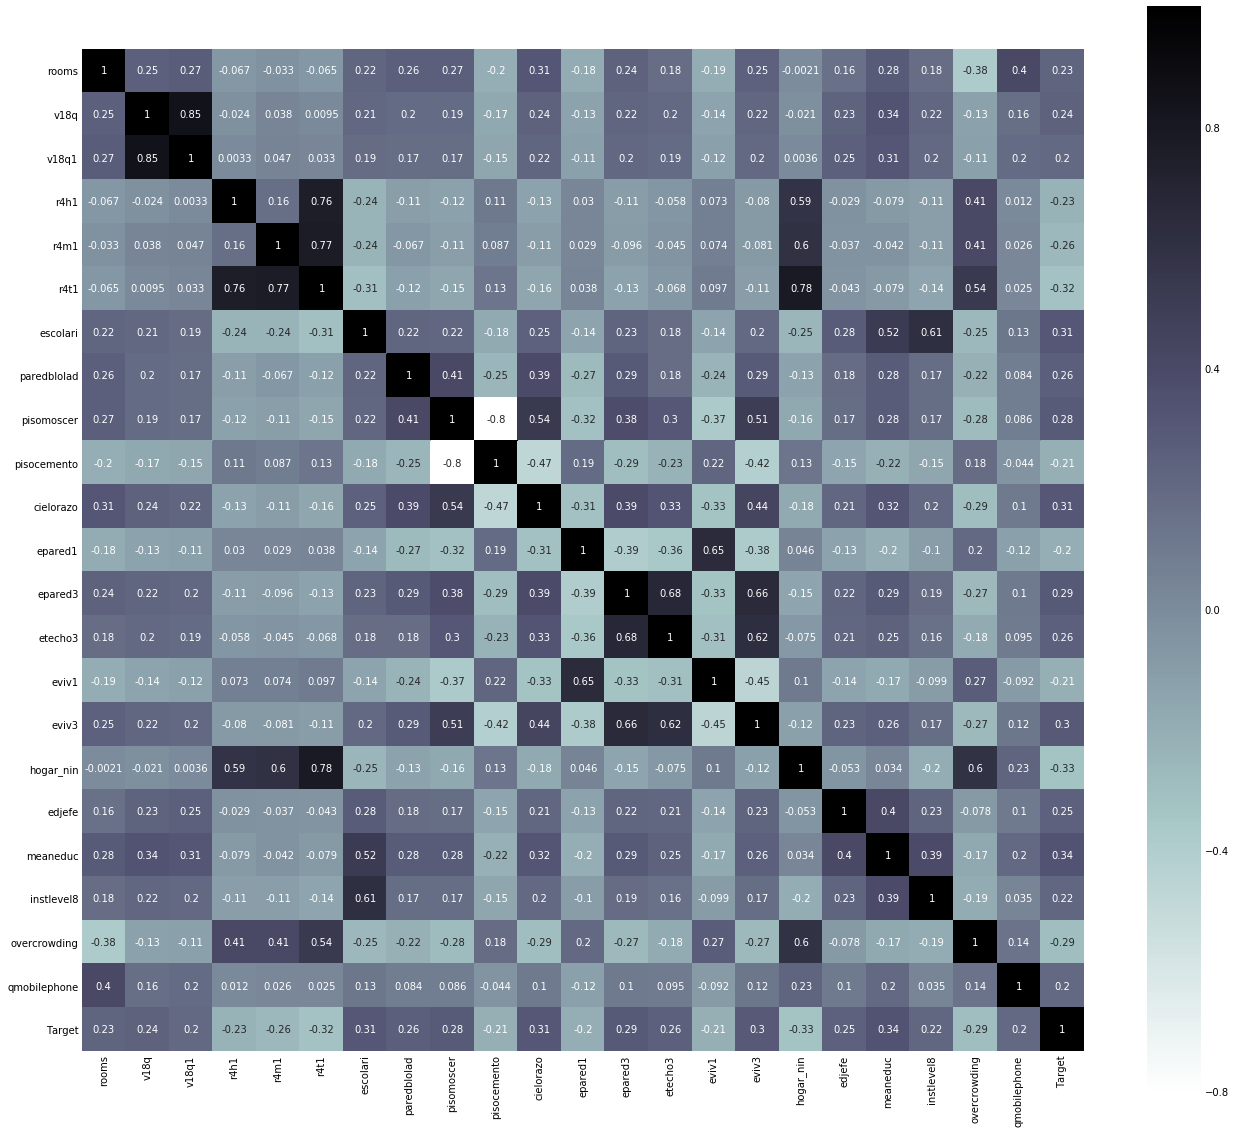

In [44]:
corr_map = data.corr() #calculate correlation coefficients
best_corr = corr_map.index[abs(corr_map["Target"])>0.2] #make subset of correlation values greater than .3
fig, ax = plt.subplots(figsize=(20,20))  #adjust size (it was a bit small the first time through)
sns.heatmap(train_df[best_corr].corr(), square = True, annot = True,  cmap="bone_r")

The coefficients seem fairly intuitive. Education variables like meaneduc, escolari, and edjefe are positively correlated with non-vulnerability. Overcrowding, number of children in the home, and cement floors, are all correlated with more vulnerable households.

# Modeling

For this project I will try two different models for classification. First I will try the random forest classifier from scikit learn, then later on I will use the XGBoost Classifier. First I have to drop the last few columns that will not be used for predicting.

In [45]:
target = data.Target
data = data.drop(columns=['Target','Id','idhogar'])

Now I will split the data into a training set (train_data, train_target) and a test set(test_data, test_target) for final scoring. I am splitting the data so that we have 70% for training and 30% for testing.

After splitting the data into training and testing sets, I further split the training set (train_data, train_target), into training(X_train, y_train) and validation sets (x_test, y_test), used for cross validation below. 

In [46]:
#splitting all data into training and test data
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.30, random_state=42)
#splitting the training data for validation 
X_train, x_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.20, random_state=42)

## Random Forest

For the random forest classifier, there are two hyper parameters I will be tuning. The depth of the trees, and the number of trees that are created in each model. I will then select the model that performs the best on the macro f1 score.

In [48]:
n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight='balanced')
        clf.fit(X_train, y_train)
        f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1), average = 'macro')
        print(est, depth, f1)
        if f1 > best_f1:
            best_f1 = f1
            best_params = (est, depth)

1000 1 0.0766017744746454
1000 3 0.08802677212585998
1000 5 0.0706181458164757
1000 10 0.032905510929634826
2500 1 0.08357192528538268
2500 3 0.08667336389961683
2500 5 0.0716036736641388
2500 10 0.03271049934223824
5000 1 0.08100922986072676
5000 3 0.08683756442891599
5000 5 0.07234026697795173
5000 10 0.03180066394869467


In [49]:
print(best_f1)
print(best_params)

0.08802677212585998
(1000, 3)


The best f1 score did pretty poorly at .09, I'm not sure if the f1 score was calculated incorrectly, I was having trouble getting the model to use the out-of-bag data for validation. However after running this a few times the random forest with 1000 decision trees with max depths of 3 performed the best. Below I will use these parameters to fit a model on all of the training data and predict on the test set.

In [50]:
clf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight='balanced')
clf.fit(train_data, train_target)
test_predictions = clf.predict(test_data)

In [51]:
print("Test Final Score Random Forest")
print('Macro f1 Score:', f1_score(test_target, test_predictions, average = 'macro'))

Test Final Score Random Forest
Macro f1 Score: 0.44291025044005533


The random forest performed pretty well. This number appears to be fairly close to some of the other kernels in the kaggle competion. While we cannot look directly at the decision trees to see how intuitive the model is, there is a way to look at the feature importance.

In [52]:
feature_imp = sorted(list(zip(data, clf.feature_importances_)), key=lambda x: x[1], reverse=True)

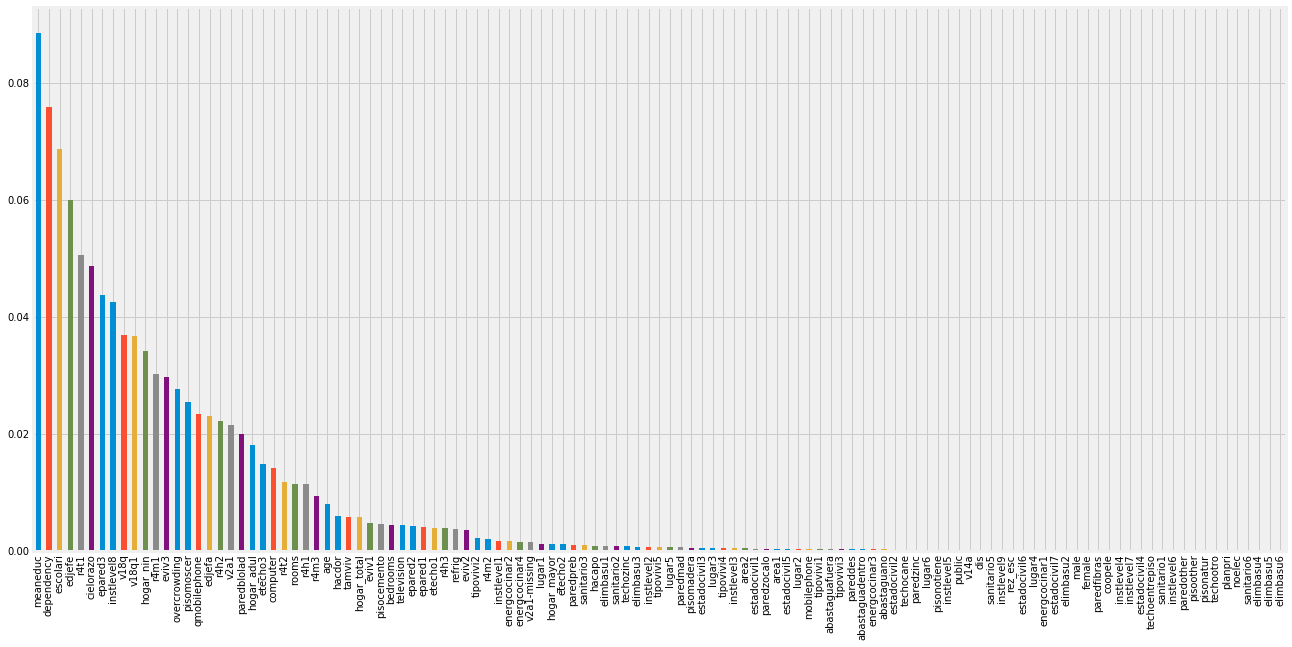

In [53]:
plt.figure(figsize=(20, 10))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

It looks like education, dependency, ceiling and wall conditions, and electronic ownership tend to be important features in the random forest. This makes sense intuitively and also correlates with the heatmap that I created above showing correlation coefficients for the features and the poverty level.

## XGBoost

Lastly, I will try to improve on the score from the random forest model using gradient boosting. While boosting is similar to random forest algorithms because they both use ensembles of decision trees, the two algorithms differ on their approach. Boosting fits one decision tree, calculates the residuals, and then fits a second decision tree using the residuals as targets. On the other hand, random forests create decision trees in parallel, so one trees residuals has no effect on the next.

I use XGBoost below, but there are a number of libraries to choose from. XGBoost is a popular boosting library because it is efficient and flexible to multible problems. It actually does have some parallelization capabilities that helps it to run faster, while still learning under the gradient boosting framework.  

In [58]:
from xgboost import XGBClassifier

First I am going to run XGBoost "out of the box" on the training set, just to get my feet wet. This is my first time using the classifier, so I just want to make sure that the library was installed correctly, and that I understand how to use it to fit models. After this test, I will work on tuning the hyperparameters to better fit future models.

In [59]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(x_test)
f1 = f1_score(y_test, y_pred, average = 'macro')

In [60]:
print("Validation score XGBoost ")
print('Macro f1 Score:', f1)

Validation score XGBoost 
Macro f1 Score: 0.5107603180112725


The intial test looks promising, so now I will fit it on the entire training set for a final model, and predict using the test data.

In [61]:
model.fit(train_data, train_target)
y_pred = model.predict(test_data)
f1 = f1_score(test_target, y_pred, average = 'macro')

In [62]:
print("Test Final Score XGBoost")
print('Macro f1 Score:', f1)

Test Final Score XGBoost
Macro f1 Score: 0.5298544032296298


This is a significant improvement on the random forest score. Lets see if we can improve it some more by changing some of the hyperparameters. Below I will test different parameters controlling, the number of estimators, the max depth of the trees, and the minimum loss reduction required to make a split. 

In [63]:
n_estimators = [500, 1000, 2500]
max_depth = [1, 3, 5]
gamma = [0, 0.5]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for gam in gamma:
            clf = XGBClassifier(
            max_depth=depth,
            min_child_weight=1,
            learning_rate=0.1,
            n_estimators=est,
            silent=True,
            objective='binary:logistic',
            gamma=gam,
            max_delta_step=0,
            subsample=1,
            colsample_bytree=1,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=0,
            scale_pos_weight=1,
            seed=1,
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average = 'macro')
            print(est, depth, gam, f1)
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, gam)

500 1 0 0.44963784035275034
500 1 0.5 0.44963784035275034
500 3 0 0.7024619014195885
500 3 0.5 0.6674914038945563
500 5 0 0.8721941339522892
500 5 0.5 0.8318126207650866
1000 1 0 0.4791562000568117
1000 1 0.5 0.4791562000568117
1000 3 0 0.7994752227315123
1000 3 0.5 0.6674914038945563
1000 5 0 0.8868488695503852
1000 5 0.5 0.8318126207650866
2500 1 0 0.5197733342923794
2500 1 0.5 0.4897689651709891
2500 3 0 0.8600995289435914
2500 3 0.5 0.6674914038945563
2500 5 0 0.8979557884996877
2500 5 0.5 0.8318126207650866


In [64]:
print('Macro f1 Score:',best_f1)
print('Parameters:',best_params)

Macro f1 Score: 0.8979557884996877
Parameters: (2500, 5, 0)


Wow! Tuning the parameters really improved on the accuracy of the model. The f1 score listed above is the score for the validation set. The model is not overfitting, as none of the validation targets (y_test) were included in the training data set used to fit the model. The parameters seem to have a significant impact on the accuracy of this model, the models with lower gammas seemed to perform much better. Using the best parameters from our search, now we can fit the model on the entire training set (train_data, test_target) and predict on the test set (test_data).

In [65]:
clf = XGBClassifier(
        max_depth=5,
        min_child_weight=1,
        learning_rate=0.1,
        n_estimators=2500,
        silent=True,
        objective='binary:logistic',
        gamma=0,
        max_delta_step=0,
        subsample=1,
        colsample_bytree=1,
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=0,
        scale_pos_weight=1,
        seed=1,
        )
clf.fit(train_data, train_target)
y_pred = clf.predict(test_data)
f1 = f1_score(test_target, y_pred, average = 'macro')

In [66]:
print('Macro f1 Score:',f1)

Macro f1 Score: 0.9227380562630549


Again, this is a huge improvement over the random forest and the "out of the box" XGBoost. Fine tuning some of the hyperparameters had a huge impact in the accuracy of the model. I had to go back multiple times to make sure that I wasn't including data from the test set in the training set to make overfitting possible. As far as I can tell the model is predicting on new data that it was not fit on. At this point I'm not sure what else I can do to 

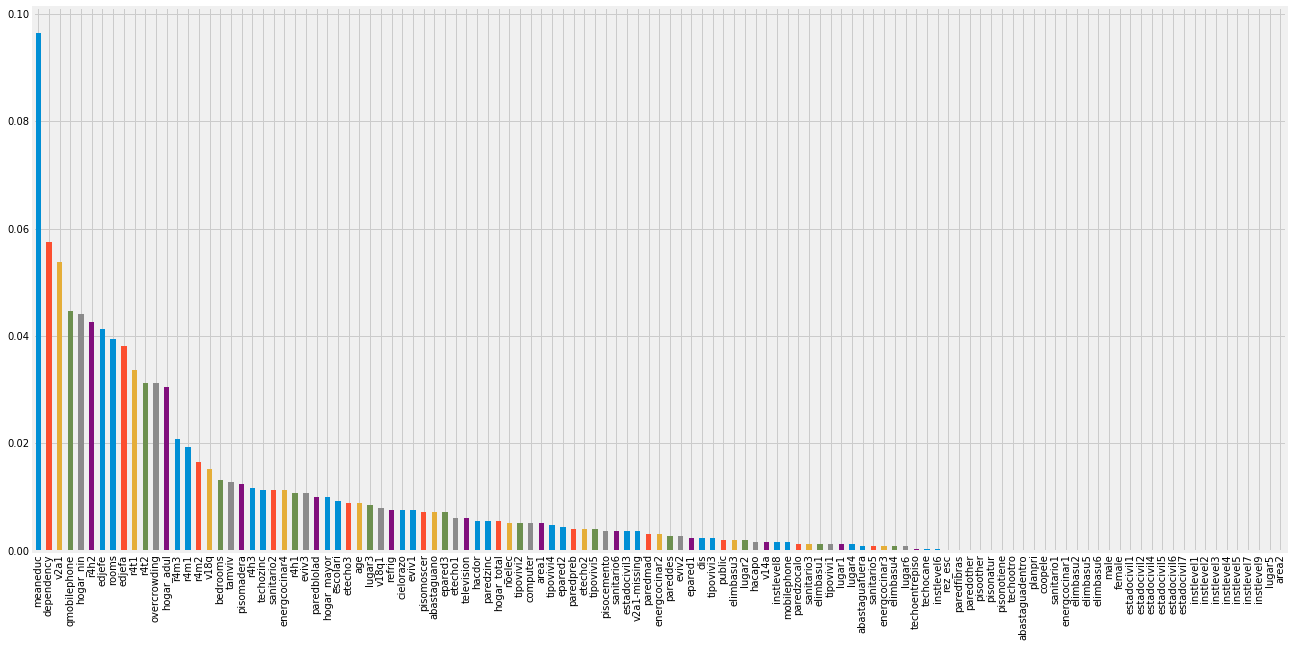

In [70]:
feature_imp = sorted(list(zip(data, model.feature_importances_)), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(20, 10))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

Like the past models, this model puts a lot of importance on mean education and dependency. Perhaps more unique to this model is the importance of v2a1, or the rent payment variable, and the mobile phone variable, which are not as important in the random forest. 

While, this model performed well on the data that i have, it is possible that the sample of data for training was not representative of the population as a whole. In which case, the model will be accurate in this data set, but not generalize well. However, given the data provided, the XGBoost model was the best model I was able to find in testing.